In [1]:
import warnings
import numpy as np
import pandas as pd
import os, json
# from sklearn.neighbors import KernelDensity
# import prose.datainsights as di

from joblib import load
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from scripts.TrainMLModels import read_json, generate_model_predictions, save_json

warnings.filterwarnings('ignore')

In [2]:
data_name = 'ACSP'

seed = 1
cur_dir = 'intermediate/models/' + data_name + '/'

test_df = pd.read_csv(cur_dir + '-'.join(['test_vio', str(seed)]) + '.csv')
test_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,Y,A,vio_G0_L0,vio_G0_L1,vio_G1_L0,vio_G1_L1
0,61.0,16.0,0.0,10800.0,2.0,1.0,5.0,1.0,6.0,2.0,...,6.0,1.0,2.0,1.0,1,0,0.330582,0.000000,0.318309,0.242961
1,19.0,18.0,0.0,12600.0,1.0,2.0,5.0,1.0,1.0,2.0,...,6.0,1.0,2.0,2.0,0,1,0.000000,0.221618,0.178414,0.297738
2,26.0,19.0,0.0,20000.0,1.0,2.0,5.0,1.0,1.0,2.0,...,6.0,3.0,2.0,2.0,0,1,0.240552,0.247406,0.277767,0.265947
3,16.0,12.0,1.0,0.0,1.0,1.0,5.0,1.0,6.0,2.0,...,6.0,1.0,2.0,2.0,0,1,0.000000,0.063247,0.000000,0.000000
4,27.0,16.0,0.0,0.0,2.0,1.0,5.0,1.0,6.0,2.0,...,6.0,1.0,2.0,2.0,0,0,0.000000,0.000000,0.000000,0.000000


In [3]:
def assign_pred_mcc(x, n_vio=4): # assign prediction based on minimal violation
    violations = [x.iloc[i] for i in range(n_vio)]
    # pred_index = violations.index(min(violations))
    if (violations[0] + violations[1]) < (violations[2] + violations[3]):
        return x.iloc[n_vio]
    else:
        return x.iloc[n_vio+1]

def assign_pred_mcc_min(x, n_vio=4): # assign prediction based on minimal violation
    violations = [x.iloc[i] for i in range(n_vio)]
    pred_index = violations.index(min(violations))
    if pred_index <= 1:
        return x.iloc[n_vio]
    else:
        return x.iloc[n_vio+1]
def assign_pred_sensi(x): # assign prediction based on the group membership of sensitive attribute
    if x.iloc[0]: # sensi_col == 1, majority group
        return x.iloc[2]
    else:
        return x.iloc[1]

In [4]:
vio_cols = ['vio_G{}_L{}'.format(group_i, label_i) for group_i in range(2) for label_i in range(2)]
y_col='Y'
sensi_col='A'
set_suffix = 'S_1'

features = [x for x in test_df.columns if x != y_col]

test_data = test_df[features]
opt_thres = read_json('{}thres-{}.json'.format(cur_dir, seed))['thres']
print('Threshold', opt_thres)
for group_suffix in [None, 'G0', 'G1']:
    if group_suffix is None:
        model = load('{}model-{}-{}.joblib'.format(cur_dir, seed, set_suffix))
        pred_col = 'Y_pred'
#         thres_key = 'thres'
    else:
        model = load('{}model-{}-{}-{}.joblib'.format(cur_dir, seed, group_suffix, set_suffix))
        pred_col = 'Y_pred_' + group_suffix
#         thres_key = 'thres_' + group_suffix[0].lower() + group_suffix[1]
   
    test_df[pred_col] = generate_model_predictions(model, test_data) #opt_thres[thres_key]




Threshold 0.37626262626262624


In [5]:
test_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X18,Y,A,vio_G0_L0,vio_G0_L1,vio_G1_L0,vio_G1_L1,Y_pred,Y_pred_G0,Y_pred_G1
0,61.0,16.0,0.0,10800.0,2.0,1.0,5.0,1.0,6.0,2.0,...,1.0,1,0,0.330582,0.000000,0.318309,0.242961,0.837568,0.892331,0.810364
1,19.0,18.0,0.0,12600.0,1.0,2.0,5.0,1.0,1.0,2.0,...,2.0,0,1,0.000000,0.221618,0.178414,0.297738,0.218739,0.254549,0.247777
2,26.0,19.0,0.0,20000.0,1.0,2.0,5.0,1.0,1.0,2.0,...,2.0,0,1,0.240552,0.247406,0.277767,0.265947,0.240944,0.292561,0.265350
3,16.0,12.0,1.0,0.0,1.0,1.0,5.0,1.0,6.0,2.0,...,2.0,0,1,0.000000,0.063247,0.000000,0.000000,0.416222,0.537901,0.457725
4,27.0,16.0,0.0,0.0,2.0,1.0,5.0,1.0,6.0,2.0,...,2.0,0,0,0.000000,0.000000,0.000000,0.000000,0.543154,0.598563,0.470736


In [6]:
def assign_pred_mcc_weight_two(x, n_vio=4): # assign prediction based on minimal violation
    weight_g1 = 1- min(x.iloc[2], x.iloc[3])
    weight_g0 = 1- min(x.iloc[0], x.iloc[1])
    norm_base = weight_g1 + weight_g0
    return weight_g0/norm_base * x.iloc[n_vio] + weight_g1/norm_base * x.iloc[n_vio+1]

In [7]:
def assign_pred_mcc_weight(x, n_vio=4): # assign prediction based on minimal violation
    vio = [1- x.iloc[i] for i in range(n_vio)]
    norm_base = sum(vio)
    return vio[0]/norm_base * (1- x.iloc[n_vio]) + vio[1]/norm_base * x.iloc[n_vio] + vio[2]/norm_base * (1- x.iloc[n_vio+1]) + vio[3]/norm_base * x.iloc[n_vio+1]

In [8]:
test_df['Y_pred_mcc_w2'] = test_df[vio_cols + ['Y_pred_G0', 'Y_pred_G1']].apply(lambda x: assign_pred_mcc_weight_two(x), axis=1)


In [9]:
test_df['Y_pred_mcc_w'] = test_df[vio_cols + ['Y_pred_G0', 'Y_pred_G1']].apply(lambda x: assign_pred_mcc_weight(x), axis=1)


In [10]:
test_df['Y_pred_mcc'] = test_df[vio_cols + ['Y_pred_G0', 'Y_pred_G1']].apply(lambda x: assign_pred_mcc_min(x), axis=1)
test_df['Y_pred_sensi'] = test_df[[sensi_col, 'Y_pred_G0', 'Y_pred_G1']].apply(lambda x: assign_pred_sensi(x), axis=1)

In [11]:
test_df['Y_pred_W2'] = test_df['Y_pred_mcc_w2'].apply(lambda x: int(x > opt_thres))
test_df['Y_pred_A'] = test_df['Y_pred_sensi'].apply(lambda x: int(x > opt_thres))
test_df['Y_pred_O'] = test_df['Y_pred'].apply(lambda x: int(x > opt_thres))

In [12]:
test_df['Y_pred_W'] = test_df['Y_pred_mcc_w'].apply(lambda x: int(x > opt_thres))
test_df['Y_pred_M'] = test_df['Y_pred_mcc'].apply(lambda x: int(x > opt_thres))

In [13]:
test_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,Y_pred_G1,Y_pred_mcc_w2,Y_pred_mcc_w,Y_pred_mcc,Y_pred_sensi,Y_pred_W2,Y_pred_A,Y_pred_O,Y_pred_W,Y_pred_M
0,61.0,16.0,0.0,10800.0,2.0,1.0,5.0,1.0,6.0,2.0,...,0.810364,0.857014,0.549252,0.892331,0.892331,1,1,1,1,1
1,19.0,18.0,0.0,12600.0,1.0,2.0,5.0,1.0,1.0,2.0,...,0.247777,0.251494,0.525587,0.254549,0.247777,0,0,0,1,0
2,26.0,19.0,0.0,20000.0,1.0,2.0,5.0,1.0,1.0,2.0,...,0.265350,0.279187,0.499545,0.292561,0.265350,0,0,0,1,0
3,16.0,12.0,1.0,0.0,1.0,1.0,5.0,1.0,6.0,2.0,...,0.457725,0.497813,0.499391,0.537901,0.457725,1,1,1,1,1
4,27.0,16.0,0.0,0.0,2.0,1.0,5.0,1.0,6.0,2.0,...,0.470736,0.534650,0.500000,0.598563,0.598563,1,1,1,1,1


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

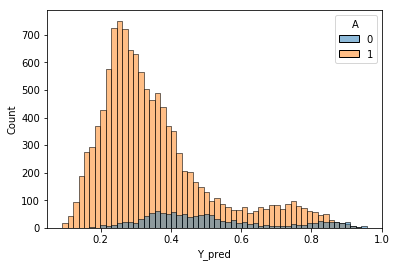

In [15]:
vis_col = 'Y_pred'
sns.histplot(x=vis_col, data=test_df, hue='A')

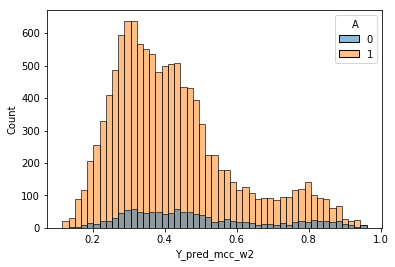

In [16]:
vis_col = 'Y_pred_mcc_w2'
sns.histplot(x=vis_col, data=test_df, hue='A')

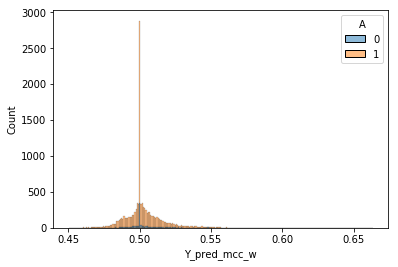

In [17]:
vis_col = 'Y_pred_mcc_w'
sns.histplot(x=vis_col, data=test_df, hue='A')

In [18]:
def compute_bal_acc(y_true, y_pred, label_order=[0, 1]):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=label_order).ravel()
    P = TP + FN
    N = TN + FP
    TPR = TP / P if P > 0.0 else np.float64(0.0)
    TNR = TN / N if N > 0.0 else np.float64(0.0)
    return 0.5 * (TPR + TNR)
def compute_sr(y_true, y_pred, label_order=[0, 1]):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=label_order).ravel()
    pred_P = TP+FP
    P = TP + FN
    N = TN + FP
    return pred_P / (P+N)
def eval_sp(test_eval_df, pred_col, sensi_col='A', n_groups=2):
    SR_all = []
    for group_i in range(n_groups):
        group_df = test_eval_df[test_eval_df[sensi_col] == group_i]
        group_sr = compute_sr(group_df['Y'], group_df[pred_col])
        SR_all.append(group_sr)

    sp_diff = SR_all[0] - SR_all[1]
    return sp_diff

In [19]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_O'])
sp_a = eval_sp(test_df, 'Y_pred_O')
acc_a, sp_a

(0.6488503000777103, 0.4138896649932855)

In [20]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_A'])
sp_a = eval_sp(test_df, 'Y_pred_A')
acc_a, sp_a

(0.652425532737809, 0.2841042880942658)

In [21]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_M'])
sp_a = eval_sp(test_df, 'Y_pred_M')
acc_a, sp_a

(0.6304971116916057, 0.13079564528015675)

In [22]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_W'])
sp_a = eval_sp(test_df, 'Y_pred_W')
acc_a, sp_a

(0.5, 0.0)

In [23]:
acc_a = compute_bal_acc(test_df['Y'], test_df['Y_pred_W2'])
sp_a = eval_sp(test_df, 'Y_pred_W2')
acc_a, sp_a

(0.6269689657611663, 0.1267807782782593)